In [1]:
import pandas as pd
import seaborn as sn
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
import keras.activations,keras.losses,keras.optimizers

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vcsaisanthosh","key":"7f4e61b1ba25a73883032d5bedf5f8ae"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d birdy654/deep-voice-deepfake-voice-recognition

100% 3.67G/3.69G [00:36<00:00, 177MB/s]
100% 3.69G/3.69G [00:36<00:00, 109MB/s]


In [6]:
!unzip deep-voice-deepfake-voice-recognition.zip

Archive:  deep-voice-deepfake-voice-recognition.zip
  inflating: DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-musk.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-obama.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-ryan.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-taylor.wav  
  inflating: KAGGLE/AUDIO/FAKE/linu

In [7]:
data=pd.read_csv("/content/KAGGLE/DATASET-balanced.csv")
print(data.columns)
print(data.describe())
print(data.isna().sum())
print(data.describe())
print(data.info())

Index(['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20', 'LABEL'],
      dtype='object')
        chroma_stft           rms  spectral_centroid  spectral_bandwidth  \
count  11778.000000  11778.000000       11778.000000        11778.000000   
mean       0.421925      0.037894        2719.201373         3050.299988   
std        0.069392      0.028071        1066.754739          872.258653   
min        0.200353      0.000043         756.163229         1096.903152   
25%        0.372330      0.015098        2062.875836         2569.289971   
50%        0.417708      0.031870        2579.963841         3055.863462   
75%        0.467741      0.054046        3283.857559         3581.271953   
max        0.707202      0.168958   

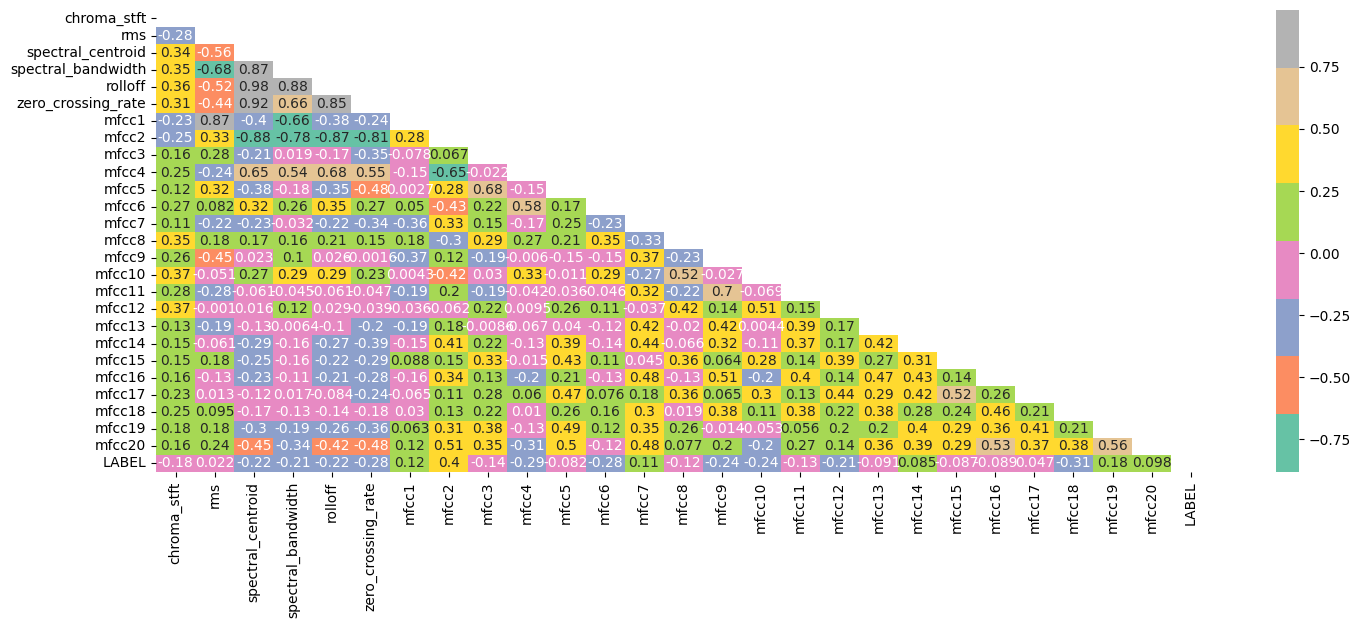

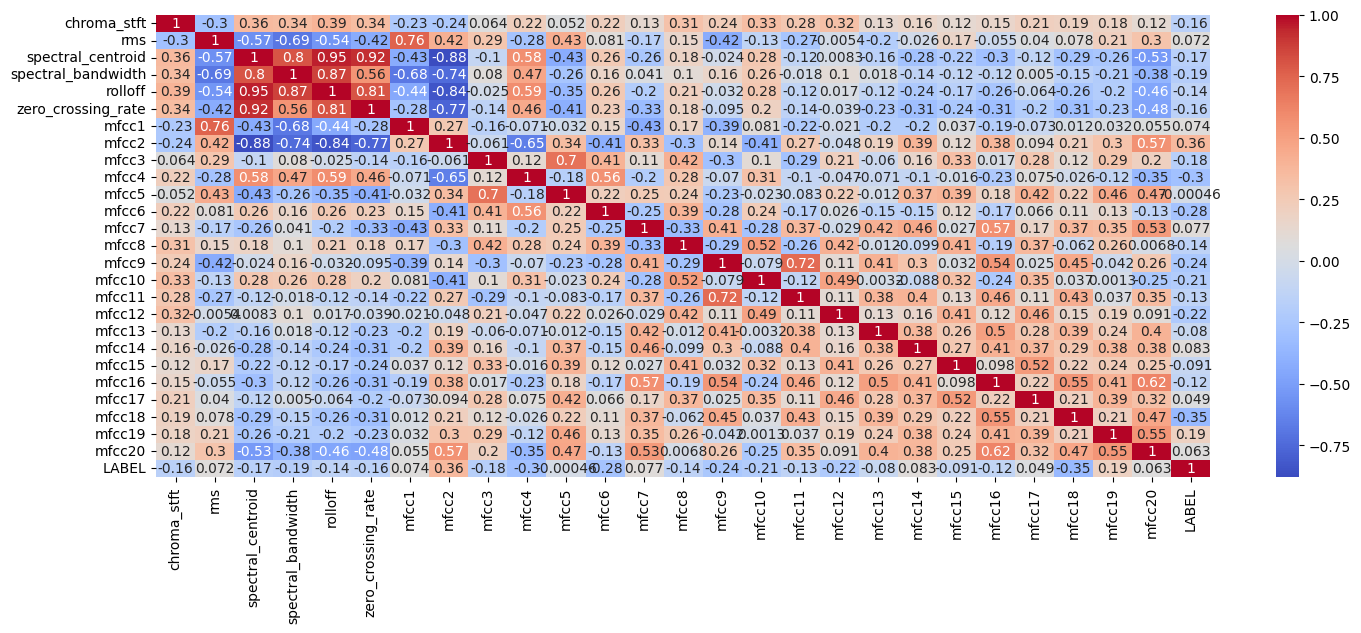

In [8]:
lab=LabelEncoder()
for i in data.select_dtypes(include='object').columns.values:
    data[i]=lab.fit_transform(data[i])

plt.figure(figsize=(17, 6))
corr = data.corr(method='spearman')
my_m = np.triu(corr)
sn.heatmap(corr, mask=my_m, annot=True, cmap="Set2")
plt.show()

plt.figure(figsize=(17,6))
correlation_matrix = data.corr()
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [9]:
noise={}
for i in data.select_dtypes(include='number').columns.values:
    data['z-scores']=(data[i]-data[i].mean())/(data[i].std())
    out=np.abs(data['z-scores'] > 3)
    if out.sum() >0:
        noise[i]=out.sum()

thresh=2.5
for i in noise:
    upper=data[i].mean()+thresh*data[i].std()
    lower=data[i].mean()-thresh*data[i].std()
    data=data[(data[i]>lower)&(data[i]<upper)]

In [10]:
lab=LabelEncoder()
for i in data.select_dtypes(include="object").columns.values:
    data[i]=lab.fit_transform(data[i])
x=[]
corr=data.corr()['LABEL']
corr=corr.drop(['LABEL','z-scores'])
for i in corr.index:
    if corr[i] >0:
        x.append(i)

In [11]:
x=data[x]
y=data['LABEL']
from lightgbm import LGBMClassifier
x_train,x_test,y_train,y_test=train_test_split(x,y)


lr = LogisticRegression(max_iter=500)
lr.fit(x_train, y_train)
print('The logistic regression: ', lr.score(x_test, y_test))

lgb = LGBMClassifier()
lgb_model = lgb.fit(x_train, y_train)
print('The LGB', lgb.score(x_test, y_test))

tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
tree.fit(x_train, y_train)
print('Dtree ', tree.score(x_test,y_test))

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
print('The Linear SVC ',linear_svc.score(x_test,y_test))

mlp_classifier = MLPClassifier()
mlp_classifier.fit(x_train, y_train)
print('The MLP classifiers ',mlp_classifier.score(x_test,y_test))

The logistic regression:  0.8045977011494253
[LightGBM] [Info] Number of positive: 3004, number of negative: 3520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 6524, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460454 -> initscore=-0.158516
[LightGBM] [Info] Start training from score -0.158516
The LGB 0.9508045977011494
Dtree  0.8381609195402299


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The Linear SVC  0.5397701149425287
The MLP classifiers  0.8951724137931034


Epoch 1/40
327/327 [==============================] - 5s 5ms/step - loss: 0.6736 - accuracy: 0.6019
Epoch 2/40
327/327 [==============================] - 2s 6ms/step - loss: 0.5854 - accuracy: 0.7310
Epoch 3/40
327/327 [==============================] - 2s 5ms/step - loss: 0.5461 - accuracy: 0.7419
Epoch 4/40
327/327 [==============================] - 1s 4ms/step - loss: 0.5250 - accuracy: 0.7463
Epoch 5/40
327/327 [==============================] - 1s 4ms/step - loss: 0.5082 - accuracy: 0.7541
Epoch 6/40
327/327 [==============================] - 1s 4ms/step - loss: 0.5087 - accuracy: 0.7515
Epoch 7/40
327/327 [==============================] - 1s 4ms/step - loss: 0.4977 - accuracy: 0.7569
Epoch 8/40
327/327 [==============================] - 1s 4ms/step - loss: 0.4915 - accuracy: 0.7635
Epoch 9/40
327/327 [==============================] - 1s 4ms/step - loss: 0.4799 - accuracy: 0.7690
Epoch 10/40
327/327 [==============================] - 2s 5ms/step - loss: 0.4622 - accuracy: 0.7768

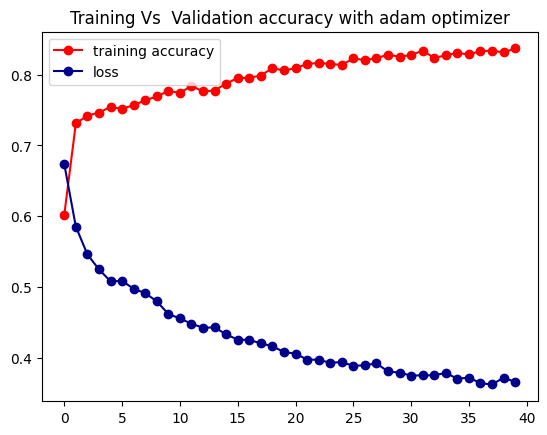

Epoch 1/40
327/327 [==============================] - 2s 4ms/step - loss: 0.6914 - accuracy: 0.5323
Epoch 2/40
327/327 [==============================] - 1s 4ms/step - loss: 0.6901 - accuracy: 0.5363
Epoch 3/40
327/327 [==============================] - 1s 4ms/step - loss: 0.6872 - accuracy: 0.5391
Epoch 4/40
327/327 [==============================] - 1s 4ms/step - loss: 0.6792 - accuracy: 0.5513
Epoch 5/40
327/327 [==============================] - 1s 4ms/step - loss: 0.6541 - accuracy: 0.6957
Epoch 6/40
327/327 [==============================] - 2s 5ms/step - loss: 0.6005 - accuracy: 0.7482
Epoch 7/40
327/327 [==============================] - 2s 5ms/step - loss: 0.5562 - accuracy: 0.7518
Epoch 8/40
327/327 [==============================] - 1s 4ms/step - loss: 0.5435 - accuracy: 0.7520
Epoch 9/40
327/327 [==============================] - 1s 4ms/step - loss: 0.5390 - accuracy: 0.7564
Epoch 10/40
327/327 [==============================] - 1s 4ms/step - loss: 0.5296 - accuracy: 0.7580

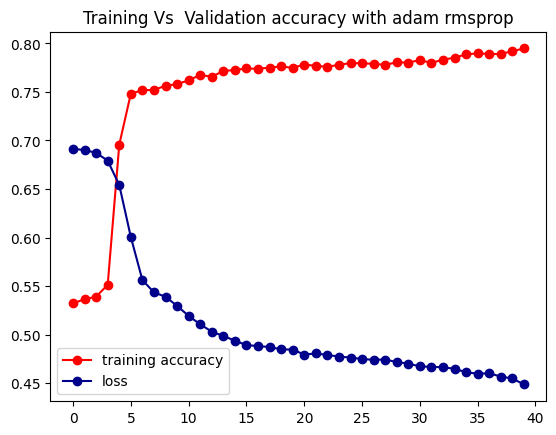

In [12]:
Y=pd.get_dummies(y)
x_tran,x_tst,y_tran,y_tst=train_test_split(x,Y)
models=Sequential()
models.add(Dense(units=x.shape[1],input_dim=x.shape[1],activation=keras.activations.relu))
models.add(Dense(units=x.shape[1],activation=keras.activations.relu))
models.add(Dense(units=x.shape[1],activation=keras.activations.tanh))
models.add(Dense(units=x.shape[1],activation=keras.activations.sigmoid))
models.add(Dense(units=x.shape[1],activation=keras.activations.sigmoid))
models.add(Dense(units=Y.shape[1],activation=keras.activations.sigmoid))
models.compile(optimizer='adam',loss=keras.losses.binary_crossentropy,metrics='accuracy')
hist=models.fit(x_tran,y_tran,batch_size=20,epochs=40)
plt.plot(hist.history['accuracy'], label='training accuracy', marker='o', color='red')
plt.plot(hist.history['loss'], label='loss', marker='o', color='darkblue')
plt.title('Training Vs  Validation accuracy with adam optimizer')
plt.legend()
plt.show()

models1=Sequential()
models1.add(Dense(units=x.shape[1],input_dim=x.shape[1],activation=keras.activations.sigmoid))
models1.add(Dense(units=x.shape[1],activation=keras.activations.sigmoid))
models1.add(Dense(units=x.shape[1],activation=keras.activations.sigmoid))
models1.add(Dense(units=x.shape[1],activation=keras.activations.sigmoid))
models1.add(Dense(units=Y.shape[1],activation=keras.activations.sigmoid))
models1.compile(optimizer='rmsprop',loss=keras.losses.binary_crossentropy,metrics='accuracy')
histo=models1.fit(x_tran,y_tran,batch_size=20,epochs=40)
plt.plot(histo.history['accuracy'], label='training accuracy', marker='o', color='red')
plt.plot(histo.history['loss'], label='loss', marker='o', color='darkblue')
plt.title('Training Vs  Validation accuracy with adam rmsprop')
plt.legend()
plt.show()

In [13]:
models1.save('deep_voice_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import joblib

joblib.dump(lgb_model, 'lgb_model.joblib')

['lgb_model.joblib']

In [15]:
loaded_lgb_model = joblib.load('lgb_model.joblib')

In [16]:
import librosa
import numpy as np

def preprocess_audio(file_path, sr=22050, n_mfcc=11, hop_length=512, n_fft=2048):
    audio, sample_rate = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    mfccs = np.mean(mfccs.T, axis=0)

    return mfccs

In [17]:
real_path = '/content/KAGGLE/AUDIO/REAL/taylor-original.wav'
fake_path = '/content/KAGGLE/AUDIO/FAKE/biden-to-taylor.wav'

In [18]:
def predict_audio(file_path, model):
    audio_features = preprocess_audio(file_path)
    audio_features = audio_features.reshape(1, -1)
    prediction = model.predict(audio_features)

    return prediction

In [19]:
def interpret_prediction(prediction):
    if prediction[0][0] > 0.5:
        return "Fake"
    else:
        return "Real"

In [20]:
prediction = predict_audio(real_path, models)
result = interpret_prediction(prediction)
print("The audio is:", result)

1/1 [==============================] - 0s 121ms/step
The audio is: Real


In [21]:
prediction = predict_audio(fake_path, models)
result = interpret_prediction(prediction)
print("The audio is:", result)

1/1 [==============================] - 0s 26ms/step
The audio is: Real


In [22]:
real_features = preprocess_audio(real_path)
fake_features = preprocess_audio(fake_path)
real_features = real_features.reshape(1, -1)
fake_features = fake_features.reshape(1, -1)

In [23]:
real_prediction = loaded_lgb_model.predict(real_features)
fake_prediction = loaded_lgb_model.predict(fake_features)

def interpret_prediction(prediction):
    if prediction[0] == 1:
        return "Fake"
    else:
        return "Real"

real_result = interpret_prediction(real_prediction)
fake_result = interpret_prediction(fake_prediction)

print("Real audio prediction:", real_result)
print("Fake audio prediction:", fake_result)

Real audio prediction: Real
Fake audio prediction: Fake


In [24]:
# Custom Audio's

from google.colab import files

uploaded = files.upload()

file_name = next(iter(uploaded))

Saving record_out.wav to record_out.wav


In [25]:
audio_features = preprocess_audio(file_name)
audio_features = audio_features.reshape(1, -1)

In [26]:
prediction = loaded_lgb_model.predict(audio_features)
result = interpret_prediction(prediction)
print("The uploaded audio file is predicted as:", result)

The uploaded audio file is predicted as: Real


In [27]:
uploaded = files.upload()

file_name = next(iter(uploaded))

Saving record_out (1).wav to record_out (1).wav


In [28]:
audio_features = preprocess_audio(file_name)
audio_features = audio_features.reshape(1, -1)

In [29]:
prediction = loaded_lgb_model.predict(audio_features)
result = interpret_prediction(prediction)
print("The uploaded audio file is predicted as:", result)

The uploaded audio file is predicted as: Real
